`Introduction`

Ce jeu de données médical vise à prédire la probabilité de survenue d'un accident vasculaire cérébral (AVC) en analysant diverses caractéristiques cliniques et démographiques des patients, telles que l'âge, l'hypertension, le taux de glucose ou encore le statut tabagique. L'objectif principal est de modéliser la variable cible binaire « stroke » à partir de l'ensemble d'entraînement, tout en relevant des défis techniques cruciaux : la gestion des valeurs manquantes (notamment pour l'IMC) et le traitement d'un fort déséquilibre des classes, les cas d'AVC étant nettement minoritaires par rapport aux cas sains.

`Traitement`

***Importation des librairies***

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, average_precision_score, classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import joblib


***1-Exploration et Analyse des Données (EAD)***

1.Chargement des données

In [13]:
df=pd.read_csv('train.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4088 entries, 0 to 4087
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 4088 non-null   int64  
 1   gender             4088 non-null   object 
 2   age                4088 non-null   float64
 3   hypertension       4088 non-null   int64  
 4   heart_disease      4088 non-null   int64  
 5   ever_married       4088 non-null   object 
 6   work_type          4088 non-null   object 
 7   Residence_type     4088 non-null   object 
 8   avg_glucose_level  4088 non-null   float64
 9   bmi                3918 non-null   float64
 10  smoking_status     4088 non-null   object 
 11  stroke             4088 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 383.4+ KB


2.Gestion des valeurs manquantes

In [14]:
df = df.drop(columns=["id"])
df["bmi"] = df["bmi"].fillna(df["bmi"].median())

3.Comparaison de la distribution des classes

In [15]:
counts = df['stroke'].value_counts()
print(counts)
print(f"\nPourcentage de cas positifs (AVC) : {round(counts[1] / len(df) * 100, 2)}%")
print(df['gender'].value_counts())

stroke
0    3889
1     199
Name: count, dtype: int64

Pourcentage de cas positifs (AVC) : 4.87%
gender
Female    2395
Male      1692
Other        1
Name: count, dtype: int64


4.Visualisation des données

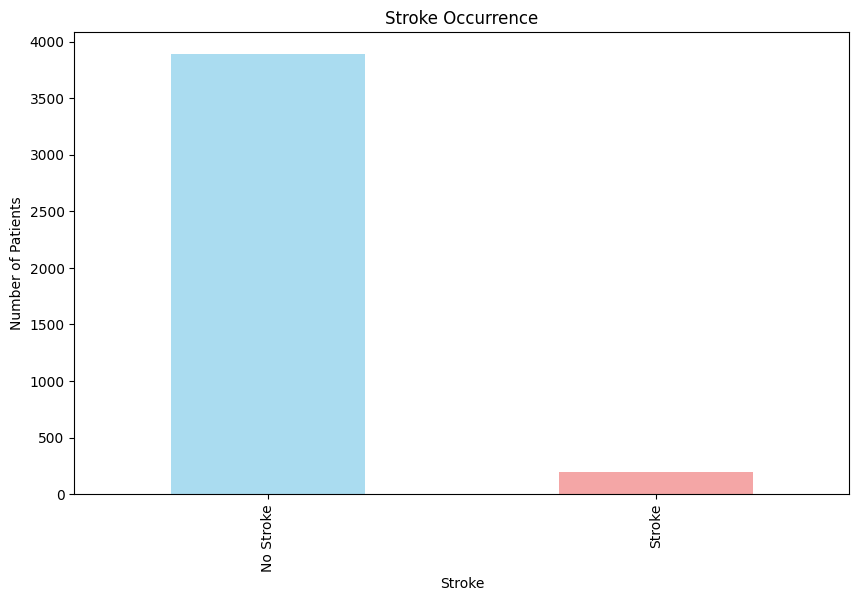

In [18]:
plt.figure(figsize=(10,6))
counts.plot(kind='bar', color=['skyblue', 'lightcoral'], alpha=0.7)
plt.xticks([0, 1], ['No Stroke', 'Stroke'])
plt.title('Stroke Occurrence')
plt.xlabel('Stroke')
plt.ylabel('Number of Patients')
plt.show()

<p style="color:#4A90E2; font-size:16px; font-weight:bold; margin-top:20px;">
Interprétation
</p>

<span style="font-size:14px; font-weight:bold;"> 
Ce graphique illustre un jeu de données déséquilibré ("imbalanced dataset"), où le cas positif (avoir un AVC) est un événement rare par rapport au reste du groupe.


***2-Prétraitement des données***

1. Création de variables d'interaction

In [19]:
df['age_bmi'] = df['age'] * df['bmi']
df['age_hypertension'] = df['age'] * df['hypertension']

2. Encodage des variables catégorielles

In [20]:
df = pd.get_dummies(df, drop_first=True)

3. Séparation des features et du label

In [ ]:
X = df.drop("stroke", axis=1)
y = df["stroke"]

4. Division des données

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

5. Standardisation des variables

In [22]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

6. Application du SMOTE

In [23]:
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X_train_scaled, y_train)


***3-Application du modèle***

1. Configuration et entraînement du modèle XGBoost pondéré

In [24]:
xgb_model = XGBClassifier(
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=4,
    scale_pos_weight=sum(y_train==0)/sum(y_train==1),  # handle imbalance
    random_state=42,
    use_label_encoder=False,
    eval_metric='auc'
)
xgb_model.fit(X_res, y_res)

c:\Users\brahi\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:199: UserWarning: [07:43:32] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'auc'


2. Extraction du Top 20 des variables les plus influentes

In [25]:
important_features = X.columns[np.argsort(xgb_model.feature_importances_)[-20:]]

3. Construction du Perceptron Multicouche

In [26]:
dl_model = Sequential([
    Dense(128, activation='relu', input_shape=(X_res.shape[1],)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

c:\Users\brahi\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4. Compilation et entraînement du modèle avec Arrêt Précoce

In [29]:
dl_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=[tf.keras.metrics.AUC(name='auc')]
)
early_stop = EarlyStopping(
    monitor='val_auc',
    patience=15,
    mode='max',
    restore_best_weights=True,
    verbose=1
)
history = dl_model.fit(
    X_res, y_res,
    validation_split=0.2,
    epochs=200,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/200
156/156 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - auc: 0.8030 - loss: 0.5176 - val_auc: 0.0000e+00 - val_loss: 0.5116
Epoch 2/200
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - auc: 0.8689 - loss: 0.4263 - val_auc: 0.0000e+00 - val_loss: 0.4900
Epoch 3/200
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - auc: 0.8897 - loss: 0.3953 - val_auc: 0.0000e+00 - val_loss: 0.4621
Epoch 4/200
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - auc: 0.8952 - loss: 0.3817 - val_auc: 0.0000e+00 - val_loss: 0.4252
Epoch 5/200
156/156 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - auc: 0.9079 - loss: 0.3604 - val_auc: 0.0000e+00 - val_loss: 0.3853
Epoch 6/200
156/156 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - auc: 0.9141 - loss: 0.3483 - val_auc: 0.0000e+00 - val_loss: 0.3359
Epoch 7/200
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - auc: 0.9219 - loss: 0.3323 - val_auc: 0.0000e+00 - val_loss: 0.3095
Epoch 8/200
156/156 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - auc: 0.9323 - loss: 0.3131 - val_auc: 0.0000e+00 - val_loss: 0.3198
Epoch 9/200
156/

5. Prédiction et optimisation du seuil de classification

In [30]:
y_pred_proba = dl_model.predict(X_test_scaled).ravel()

# Tune threshold for best F1/AUC
thresholds = np.linspace(0.1, 0.9, 81)
best_auc = 0
best_threshold = 0.5
for t in thresholds:
    y_pred_temp = (y_pred_proba >= t).astype(int)
    auc = roc_auc_score(y_test, y_pred_temp)
    if auc > best_auc:
        best_auc = auc
        best_threshold = t

y_pred = (y_pred_proba >= best_threshold).astype(int)

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


6. Évaluation finale des performances du modèle

In [31]:
print("\n=== FINAL VALIDATION REPORT ===\n")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_pred_proba))
print("PR-AUC:", average_precision_score(y_test, y_pred_proba))
print("Best Threshold:", best_threshold)


=== FINAL VALIDATION REPORT ===

              precision    recall  f1-score   support

           0       0.99      0.72      0.83       778
           1       0.14      0.88      0.24        40

    accuracy                           0.72       818
   macro avg       0.56      0.80      0.53       818
weighted avg       0.95      0.72      0.80       818

Confusion Matrix:
 [[558 220]
 [  5  35]]
ROC-AUC: 0.8531169665809769
PR-AUC: 0.1906687557995557
Best Threshold: 0.33999999999999997


<p style="color:#4A90E2; font-size:16px; font-weight:bold; margin-top:20px;">
Interprétation
</p>

<span style="font-size:14px; font-weight:bold;"> 
Ce modèle a surtout cherché à ne rater aucun malade. Il y arrive bien puisqu'il détecte 35 des 40 vrais cas d'AVC. Le revers de la médaille, c'est qu'il est trop sensible : pour attraper ces cas, il a dû lancer l'alerte sur 220 personnes qui étaient pourtant en bonne santé. En résumé, le modèle détecte très bien le danger, mais il fait aussi beaucoup de fausses alertes.

***4-Sauvegarde du modèle***

In [32]:
dl_model.save("stroke_best_dl_model.h5")
joblib.dump(scaler, "scaler.pkl")
print("Deep learning model saved as stroke_best_dl_model.h5 and scaler saved as scaler.pkl")

Deep learning model saved as stroke_best_dl_model.h5 and scaler saved as scaler.pkl


`Conclusion`

Ce travail montre qu'il est difficile, mais possible, de prédire un événement rare comme l'AVC. Le modèle a été configuré pour être très vigilant : il réussit à identifier presque tous les cas positifs, mais au prix d'une précision faible sur les cas sains. Le résultat est donc un outil de dépistage utile pour ne rater personne, mais qui demande un filtrage humain supplémentaire.